# Quick recap

To get started, we need to make sure we have the right packages. The packages for surrogate construction and plotting is `tesuract` and `clif`. `tesuract` can be downloaded using `pip install tesuract` or getting the source from [here](https://github.com/kennychowdhary/tesuract). `clif` is a private repo and you should have got an invitation to be a collaborator. The link is [here](https://github.com/kennychowdhary/clif). We will use `clif` for plotting and some preprocessing transforms, but it is not required. 

These packages, and other will require the following third party libraries:

```
xarray
dask
numpy 
matplotlib
netcdf4
scikit-learn
cartopy (optional)
```

Once you have all those packages installed, we can begin loading and plotting the data. 

## Understanding the data

The data is saved as a netcdf file, which is similar to a pandas style data frame. We will load is as an xarray data set which will allow us to load a whole bunch of meta data along with the numpy arrays. For example, the data sets we will be looking at are latitude-longitude fields. If we were to import the data as a pure numpy array, we would lose the latitude or longitude indices associated with each row and column of the data set. xarray allows us to store that information. It is a mix between pandas and numpy, and it becoming increasingly utilized in the climate world. 

The data sets are broken up by seasons (DJF - December, January, February). So for DJF/ winter, we have two separate `*.nc` files or netcdf files. `lat_lon_10yr_24x48_DJF.nc` contains simulation data from 250 independent runs of E3SM. It contains different climatologies or outputs of the model such as shortwave and longwave cloud forcing, and total precipitation. Let's see how to load this data and what it looks like. 

In [2]:
import numpy as np
import xarray as xr
import dask

In [26]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})

For our purposes, we will only need a few of these variables. The variables of interest will be 

```
SWCF (shortwave cloud forcing W/m^2)
LWCF (longwave cloud forcing W/m^2)
PRECT (total precipitation m/day)
area (latitude/ longitude area weights of grids, not equally spaced)
lhs (Latin hypercuve sampling tuning parameters/ feature space samples X)
lhs_bnds (bounds on feature space parameters - for re-scaling)
```

Let's extract the SWCF variable and the LHS points 

In [27]:
# Extract the training data for SWCF
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

Now that we extracted the training data, let's explore its shape. The first dimension is always the sampling dimension, as standard in ML. Thus, each row of the dataset corresponds to a different sample

$X$ is of size $250 \times 5$ corresponding to $250$ training samples and $5$-dimensional feature space. Each row represents a different set of parameters and the corresponding E3SM model simulation output is given in $Y$. 

$Y$ is of size $250 \times 24 \times 48$, thus each sample of $Y$ is a $24\times48$ *image* or spatially varying latitude-longitude field. As you can see above, $Y$ is a three dimensional tensor (it's actually 4 but we ignore the time), with latitude and longitude coordinates. 

$(X,Y)$ represent input/ output pairs of the E3SM climate model. We will use this data to creat a regression model that maps/ interpolates $X$ to $Y$. We do this so we can calibrate the climate model, i.e., we want to find the optimal input value such that $Y$ matches some observed climate data. That is, 

$$x^* = \arg \min_{x} \|Y_{\mathrm{E^3SM}}(x) - Y_{\mathrm{obs}} \| $$

Since E3SM is too computationally expensive, instead, we solve 

$$x^* = \arg \min_{x} \|Y_{\mathrm{surrogate}}(x) - Y_{\mathrm{obs}} \| $$, 

where we replace the full model with a machine learning surrogate. This optimization can be solved quickly given that the surrogate is differentiable and easy to evaluate. 

This observed data can be loaded from the corresponding netcdf file from the same data directory.   

In [28]:
cd ../../../icme-xplore-bayes-spring22/src/data

/home/misbah/Desktop/CS 229/Project/icme-xplore-bayes-spring22/src/data


In [29]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"lat_lon_24x48_{season}_obs.nc", chunks=1)
Y_obs = dataset_obs['SWCF']

## Analyzing the model error



In [30]:
error = Y - Y_obs
print(error.shape)
error

/home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/dask/array/core.py:4299: PerformanceWarning: Increasing number of chunks by factor of 250
  **blockwise_kwargs,


(250, 24, 48)


,Array,Chunk
Bytes,1.15 MB,4 B
Shape,"(250, 24, 48)","(1, 1, 1)"
Count,866556 Tasks,288000 Chunks
Type,float32,numpy.ndarray


In [35]:
# Normalize the error by the spatial variance of the observations
var_obs = Y_obs.var()
error_scaled = error / np.sqrt(var_obs)
type(error_scaled)

xarray.core.dataarray.DataArray

/home/misbah/anaconda3/envs/proj-env/lib/python3.6/site-packages/clif/visualization/contour.py:260: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(self.cplt_, cax=cbax, drawedges=True, alpha=0.5)


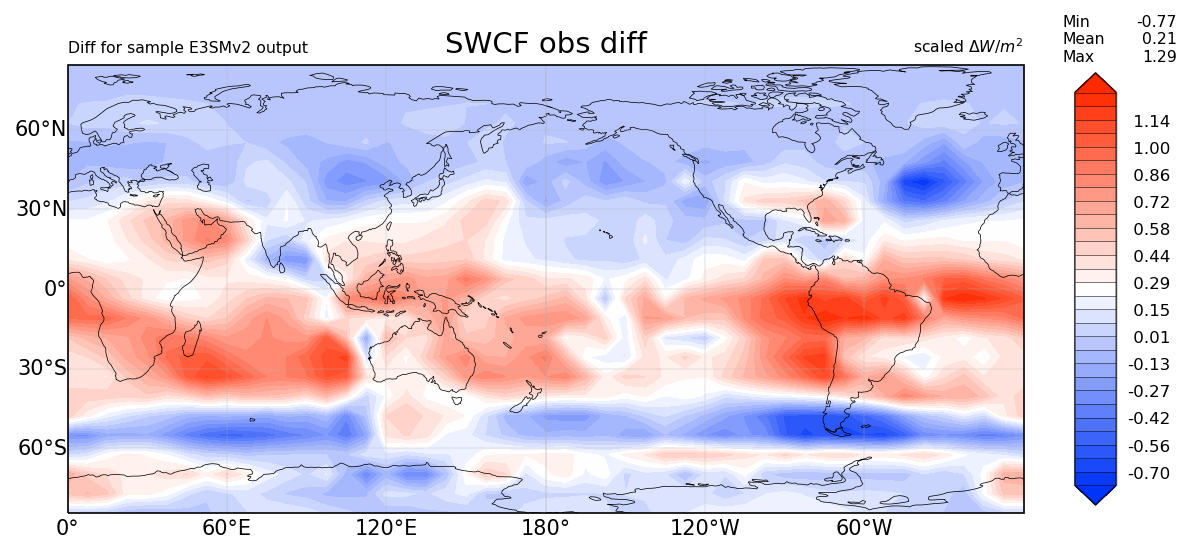

In [32]:
# let's plot some of the differences
import clif.visualization as cviz

diff_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="SWCF obs diff",
    rhs_title=r"scaled $\Delta W/m^2$",
    lhs_title="Diff for sample E3SMv2 output",
)
diff_plot.show(error_scaled[1])